# General BERT Attention Analysis

This notebook contains code for analyzing general patterns BERT's attention (see Sections 3 and 6 of [What Does BERT Look At? An Analysis of BERT's Attention](https://arxiv.org/abs/1906.04341))

In [41]:
import collections
import pickle

import matplotlib
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib import cm

sns.set_style("darkgrid")

### Loading the Data
You can download the data used for the notebook [here](https://drive.google.com/open?id=1DEIBQIl0Q0az5ZuLoy4_lYabIfLSKBg-). You can create your own data and extract your own attention maps using `preprocess_unlabeled.py` and `extract_attention.py` (see the README for details).

In [42]:
def load_pickle(fname):
    with open(fname, "rb") as f:
        return pickle.load(f)  # add, encoding="latin1") if using python3 and downloaded data

# BERT-base Attention Maps extracted from Wikipedia
# Data is a list of dicts of the followig form:
# {
#    "tokens": list of strings
#    "attns": [n_layers, n_heads, n_tokens, n_tokens] 
#             tensor of attention weights
# }
models_list = [
    # Bert-base-mult
    "test_results_i0_e5_sra-20-srubert-large-neut-nli-pretrained-3l-a-raw.bert_base_mult_attn.pkl",
    # SentenceRuBERT
    "test_results_i0_e5_sra-20-srubert-large-neut-nli-pretrained-3l-a-raw.sentence_ru_cased_attn.pkl",
    # SentenceRuBERT + fine-tunning ra-20-ln
    "test_results_i0_e5_sra-20-srubert-large-neut-nli-pretrained-3l-a-raw.sentence_ru_cased_20ln_attn.pkl",
]

data = load_pickle("./output/rsr-v1_1-fixed-balanced-tpc50_3l/"+
                   "bert-nli_m-sharp-simple-3l-ra-20ln/"+
                   models_list[0])
n_docs = len(data)

# Average Jenson-Shannon divergences between attention heads
# js_divergences = load_pickle("./data/head_distances.pkl")


def data_iterator():
  for i, doc in enumerate(data):
    if i % 100 == 0 or i == len(data) - 1:
      print("{:.1f}% done".format(100.0 * (i + 1) / len(data)))
    yield doc["tokens"], np.array(doc["attns"])

### Computing Average Attention to Particular Tokens/Positions (Sections 3.1 and 3.2 of the Paper)

In [43]:
from map_tokens import process_tokens, read_lexicon, iter_from_file

# declaring keys.
FRAMES_KEY = "a0-a1"
SENTS_KEY = "sents"
PREPS_KEY = "preps"
CONJS_KEY = "conj"

# Reading vocabularies from filepaths
vocabs = {
  SENTS_KEY: set(read_lexicon("data/rusentilex.csv")),
  FRAMES_KEY: set(iter_from_file("data/rusentiframes_a0_to_a1.txt")),
  'subj_obj': set(['s', 'o']),
  PREPS_KEY: set(['к', 'на', 'по', 'с', 'до', 'в', 'во', "у"]),
  CONJS_KEY: set(['и', 'но', 'а']) 
}

In [44]:
n_docs_with_frames = 0
n_docs_with_sents = 0
for tokens, attns in data_iterator():
  # label for vocabulary based elements.
  vocab_entries_stat = process_tokens(tokens=tokens, vocabs=vocabs)
  
  # updating docs count, related to the particular vocab.  
  if vocab_entries_stat[FRAMES_KEY] > 0:
    n_docs_with_frames += 1 
  if vocab_entries_stat[SENTS_KEY] > 0:
    n_docs_with_sents += 1
    
print("Docs with frames: {}".format(n_docs_with_frames))
print("Docs with sentiment words: {}".format(n_docs_with_sents))

0.1% done
10.0% done
19.8% done
29.7% done
39.5% done
49.4% done
59.2% done
69.1% done
78.9% done
88.8% done
98.6% done
100.0% done
Docs with frames: 341
Docs with sentiment words: 296


In [ ]:
avg_attns = {
    k: np.zeros((12, 12)) for k in [
      "self", "right", "left", "sep", "sep_sep", "rest_sep", "rest_preps", "rest_conjs", 
      "rest_so", "frames_rest", "rest_frames",
      "cls", FRAMES_KEY, "frames", "punct", SENTS_KEY, "subj_obj", PREPS_KEY, CONJS_KEY]
}

print("Computing token stats")

for tokens, attns in data_iterator():
  n_tokens = attns.shape[-1]

  # create masks indicating where particular tokens are
  seps, clss, puncts, frames, sents, subj_obj, preps, conjs = (np.zeros(n_tokens) for _ in range(8))
  
  for position, token in enumerate(tokens):
    if token == "[SEP]":
      seps[position] = 1
    if token == "[CLS]":
      clss[position] = 1
    if token == "." or token == ",":
      puncts[position] = 1
    
  def handle(token_positions, vocab_word, vocab_name):
    # Defining the target array.
    if vocab_name == FRAMES_KEY:
        target = frames
    elif vocab_name == SENTS_KEY:
        target = sents
    elif vocab_name == PREPS_KEY:
        target = preps
    elif vocab_name == CONJS_KEY:
        target = conjs
    elif vocab_name == "subj_obj":
        target = subj_obj
    else:
        return
    
    # Updating mentions by token positions.
    for p in token_positions:
        target[p] = 1
  
  # label for vocabulary based elements.
  vocab_stat = process_tokens(tokens=tokens, vocabs=vocabs, handle=handle)
    
  # create masks indicating which positions are relevant for each key
  sep_seps = np.ones((n_tokens, n_tokens))
  sep_seps *= seps[np.newaxis]
  sep_seps *= seps[:, np.newaxis]

  rest_seps = np.ones((n_tokens, n_tokens))
  rest_seps *= (np.ones(n_tokens) - seps)[:, np.newaxis]
  rest_seps *= seps[np.newaxis]

  rest_preps = np.ones((n_tokens, n_tokens))
  rest_preps *= (np.ones(n_tokens) - preps)[:, np.newaxis]
  rest_preps *= preps[np.newaxis]
    
  rest_conjs = np.ones((n_tokens, n_tokens))
  rest_conjs *= (np.ones(n_tokens) - conjs)[:, np.newaxis]
  rest_conjs *= conjs[np.newaxis]

  # how frames attend to the rest of input.
  frames_rest = np.ones((n_tokens, n_tokens))
  frames_rest *= frames[np.newaxis]
  frames_rest *= (np.ones(n_tokens) - frames)[:, np.newaxis]

  rest_frames = np.ones((n_tokens, n_tokens))
  rest_frames *= (np.ones(n_tokens) - frames)[:, np.newaxis]
  rest_frames *= frames[np.newaxis]

  rest_so = np.ones((n_tokens, n_tokens))
  rest_so *=  (np.ones(n_tokens) - subj_obj)[:, np.newaxis] 
  rest_so *= subj_obj[np.newaxis]

  selectors = {
      "self": np.eye(n_tokens, n_tokens),
      "right": np.eye(n_tokens, n_tokens, 1),
      "left": np.eye(n_tokens, n_tokens, -1),
      "sep": np.tile(seps[np.newaxis], [n_tokens, 1]),
      "sep_sep": sep_seps,
      "rest_preps": rest_preps,
      "rest_sep": rest_seps,
      "rest_conjs": rest_conjs,
      "rest_so": rest_so,
      "frames_rest": frames_rest,
      "rest_frames": rest_frames,
      "cls": np.tile(clss[np.newaxis], [n_tokens, 1]),
      FRAMES_KEY: np.tile(frames[np.newaxis], [n_tokens, 1]),
      "subj_obj": np.tile(subj_obj[np.newaxis], [n_tokens, 1]),
      SENTS_KEY: np.tile(sents[np.newaxis], [n_tokens, 1]),
      PREPS_KEY: np.tile(preps[np.newaxis], [n_tokens, 1]),
      "punct": np.tile(puncts[np.newaxis], [n_tokens, 1]),
      CONJS_KEY: np.tile(conjs[np.newaxis], [n_tokens, 1])
  }

  # get the average attention for each token type
  for key, selector in selectors.items():
        
    # estimating amount of the relevant tokens in context.
    if key == "sep_sep":
      denom = 2
    elif key == "rest_sep":
      denom = n_tokens - 2
    elif key == "rest_so":
      denom = n_tokens - 2
    elif key == "rest_prep":
      # ok, since these entries are quite short
      denom = n_tokens - vocab_stat[PREPS_KEY]
    elif key == "rest_conjs":
      denom = n_tokens - vocab_stat[CONJS_KEY]
    # TODO. Bug. Provide and use tokens stat.
    # since every entry may present as multiple tokens.
    elif key == "frames_rest":
      f_count = vocab_stat[FRAMES_KEY] 
      if f_count == 0:
        continue
      denom = f_count
    elif key == "rest_frames":
      # TODO. Bug. Provide and use tokens stat.
      # since every entry may present as multiple tokens.
      f_count = vocab_stat[FRAMES_KEY]  
      if f_count == 0:
        continue
      denom = n_tokens - f_count
    else:
      denom = n_tokens
    
    if key == FRAMES_KEY:
      docs_total = n_docs_with_frames
    elif key == SENTS_KEY:
      docs_total = n_docs_with_sents
    else:
      docs_total = n_docs
   
    avg_attns[key] += (
        (attns * selector[np.newaxis, np.newaxis]).sum(-1).sum(-1) /
        (total_docs * denom))

Computing token stats
0.1% done
10.0% done
19.8% done
29.7% done
39.5% done
49.4% done
59.2% done
69.1% done


### Computing Attention Head Entropies (Section 3.3)

In [10]:
uniform_attn_entropy = 0  # entropy of uniform attention
entropies = np.zeros((12, 12))  # entropy of attention heads
entropies_cls = np.zeros((12, 12))  # entropy of attention from [CLS]

print("Computing entropy stats")
for tokens, attns in data_iterator():
  attns = 0.9999 * attns + (0.0001 / attns.shape[-1])  # smooth to avoid NaNs
  uniform_attn_entropy -= np.log(1.0 / attns.shape[-1])
  entropies -= (attns * np.log(attns)).sum(-1).mean(-1)
  entropies_cls -= (attns * np.log(attns))[:, :, 0].sum(-1)

uniform_attn_entropy /= n_docs
entropies /= n_docs
entropies_cls /= n_docs

Computing entropy stats
0.1% done
10.0% done
19.8% done
29.7% done
39.5% done
49.4% done
59.2% done
69.1% done
78.9% done
88.8% done
98.6% done
100.0% done


### Plotting Utilities

In [38]:
# Pretty colors
BLACK = "k"
GREEN = "#59d98e"
SEA = "#159d82"
BLUE = "#3498db"
PURPLE = "#9b59b6"
GREY = "#95a5a6"
RED = "#e74c3c"
ORANGE = "#f39c12"

In [39]:
def get_data_points(head_data):
  xs, ys, avgs = [], [], []
  for layer in range(12):
    for head in range(12):
      ys.append(head_data[layer, head])
      xs.append(1 + layer)
    avgs.append(head_data[layer].mean())
  return xs, ys, avgs

### Examples of Attention Head Behavior (Figure 1)

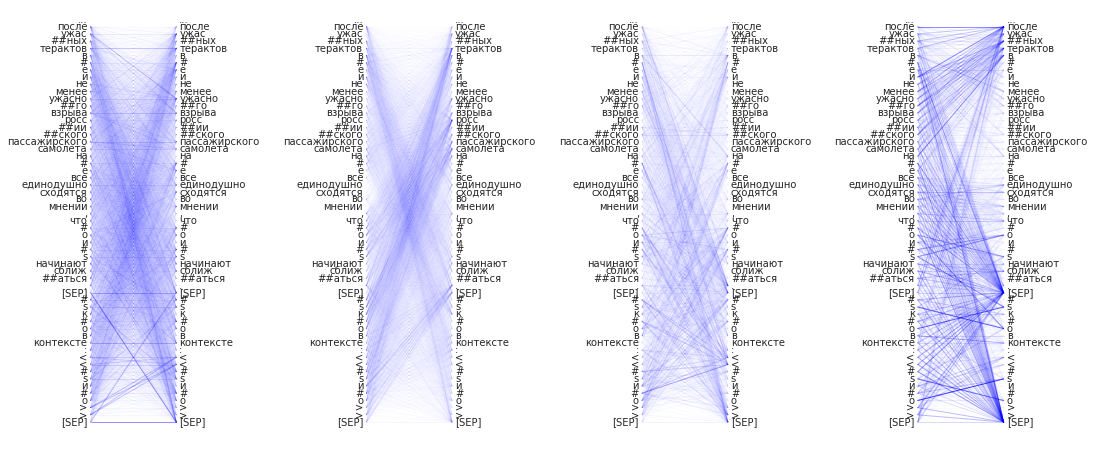

In [12]:
width = 3
example_sep = 3
word_height = 1
pad = 0.1


def plot_attn(example, heads):
  """Plots attention maps for the given example and attention heads."""

  for ei, (layer, head) in enumerate(heads):
    yoffset = 1
    xoffset = ei * width * example_sep

    attn = example["attns"][layer][head][0:80, 0:80]
    attn = np.array(attn)
    attn /= attn.sum(axis=-1, keepdims=True)
    words = example["tokens"][0:80]
    words[0] = "..."
    n_words = len(words)

    for position, word in enumerate(words):
      plt.text(xoffset + 0, yoffset - position * word_height, word,
               ha="right", va="center")
      plt.text(xoffset + width, yoffset - position * word_height, word,
               ha="left", va="center")
    for i in range(1, n_words):
      for j in range(1, n_words):
        plt.plot([xoffset + pad, xoffset + width - pad],
                 [yoffset - word_height * i, yoffset - word_height * j],
                 color="blue", linewidth=1, alpha=attn[i, j])

plt.figure(figsize=(18, 8))
plt.axis("off")
plot_attn(data[60], [(0, 0), (2, 0), (4, 0), (8, 0)])
plt.show()

### Avg. Attention Plots (Figure 2, Sections 3.1 and 3.2)

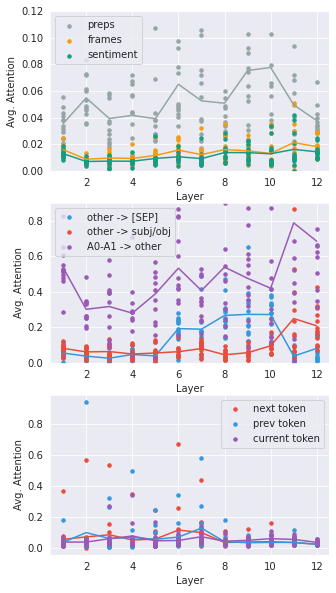

In [33]:
def add_line(key, ax, color, label, plot_avgs=True):
  xs, ys, avgs = get_data_points(avg_attns[key])
  ax.scatter(xs, ys, s=12, label=label, color=color)
  if plot_avgs:
    ax.plot(1 + np.arange(len(avgs)), avgs, color=color)
  ax.legend(loc="best")
  ax.set_xlabel("Layer")
  ax.set_ylabel("Avg. Attention")


plt.figure(figsize=(5, 10))
ax = plt.subplot(3, 1, 1)
ax.set_ylim([0,0.12])
for key, color, label in [
    # ("cls", RED, "[CLS]"),
    # ("sep", BLUE, "[SEP]"),
    (PREPS_KEY, GREY, "preps"),
    # (CONJS_KEY, BLACK, "conjs"),
    (FRAMES_KEY, ORANGE, "frames"),
    # ("subj_obj", PURPLE, "so"),
    (SENTS_KEY, SEA, "sentiment")
]:
  add_line(key, ax, color, label)

ax = plt.subplot(3, 1, 2)
ax.set_ylim([0,0.9])
for key, color, label in [
    ("rest_sep", BLUE, "other -> [SEP]"),
    # ("rest_frames", PURPLE, "other -> A0-A1"),
    ("rest_so", RED, "other -> subj/obj"),
    # ("frames_rest", PURPLE, "A0-A1 -> other"),
    # ("sep_sep", GREEN, "[SEP] -> [SEP]"),
    # ("rest_preps", SEA, "other -> preps"),
    # ("rest_conjs", PURPLE, "other -> conjs")
]:
  add_line(key, ax, color, label)

ax = plt.subplot(3, 1, 3)
for key, color, label in [
    ("left", RED, "next token"),
    ("right", BLUE, "prev token"),
    ("self", PURPLE, "current token"),
]:
  add_line(key, ax, color, label, plot_avgs=True)

plt.show()

### Entropy Plots (Section 3.3, Figure 4)

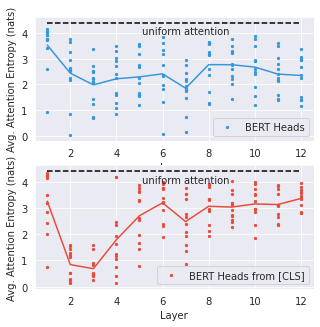

In [40]:
xs, es, avg_es = get_data_points(entropies)
xs, es_cls, avg_es_cls = get_data_points(entropies_cls)

plt.figure(figsize=(5, 5))


def plot_entropies(ax, data, avgs, label, c):
  ax.scatter(xs, data, c=c, s=5, label=label)
  ax.plot(1 + np.arange(12), avgs, c=c)
  ax.plot([1, 12], [uniform_attn_entropy, uniform_attn_entropy],
          c="k", linestyle="--")
  ax.text(7, uniform_attn_entropy - 0.45, "uniform attention",
          ha="center")
  ax.legend(loc="lower right")
  ax.set_ylabel("Avg. Attention Entropy (nats)")
  ax.set_xlabel("Layer")

plot_entropies(plt.subplot(2, 1, 1), es, avg_es, "BERT Heads",
               c=BLUE)
plot_entropies(plt.subplot(2, 1, 2), es_cls, avg_es_cls,
               "BERT Heads from [CLS]", c=RED)

plt.show()

### Clustering Attention Heads (Section 6, Figure 6)

In [39]:
ENTROPY_THRESHOLD = 3.8  # When to say a head "attends broadly"
POSITION_THRESHOLD = 0.5  # When to say a head "attends to next/prev"
SPECIAL_TOKEN_THRESHOLD = 0.6  # When to say a heads attends to [CLS]/[SEP]"
# Heads that were found to have linguistic behaviors
LINGUISTIC_HEADS = {
    (4, 3): "Coreference",
    (7, 10): "Determiner",
    (7, 9): "Direct object",
    (8, 5): "Object of prep.",
    (3, 9): "Passive auxiliary",
    (6, 5): "Possesive",
}

# Use multi-dimensional scaling to compute 2-dimensional embeddings that
# reflect Jenson-Shannon divergences between attention heads.
mds = sklearn.manifold.MDS(metric=True, n_init=5, n_jobs=4, eps=1e-10,
                           max_iter=1000, dissimilarity="precomputed")
pts = mds.fit_transform(js_divergences)
pts = pts.reshape((12, 12, 2))
pts_flat = pts.reshape([144, 2])

colormap = cm.seismic(np.linspace(0, 1.0, 12))
plt.figure(figsize=(4.8, 9.6))
plt.title("BERT Attention Heads")

for color_by_layer in [False, True]:
  ax = plt.subplot(2, 1, int(color_by_layer) + 1)
  seen_labels = set()
  for layer in range(12):
    for head in range(12):
      label = ""
      color = GREY
      marker = "o"
      markersize = 4
      x, y = pts[layer, head]

      if avg_attns["right"][layer, head] > POSITION_THRESHOLD:
        color = RED
        marker = ">"
        label = "attend to next"
        
      if avg_attns["left"][layer, head] > POSITION_THRESHOLD:
        color = BLUE
        label = "attend to prev."
        marker = "<"

      if entropies[layer, head] > ENTROPY_THRESHOLD:
        color = ORANGE
        label = "attend broadly"
        marker = "^"

      if avg_attns["cls"][layer, head] > SPECIAL_TOKEN_THRESHOLD:
        color = PURPLE
        label = "attend to [CLS]"
        marker = "$C$"
        markersize = 5

      if avg_attns["sep"][layer, head] > SPECIAL_TOKEN_THRESHOLD:
        color = GREEN
        marker = "$S$"
        markersize = 5
        label = "attend to [SEP]"

      if avg_attns["punct"][layer, head] > SPECIAL_TOKEN_THRESHOLD:
        color = SEA
        marker = "s"
        markersize = 3.2
        label = "attend to . and ,"

      if color_by_layer:
        label = str(layer + 1)
        color = colormap[layer]
        marker = "o"
        markersize = 3.8

      if not color_by_layer:
        if (layer, head) in LINGUISTIC_HEADS:
          label = ""
          color = BLACK
          marker = "x"
          ax.text(x, y, LINGUISTIC_HEADS[(layer, head)], color=color)

      if label not in seen_labels:
        seen_labels.add(label)
      else:
        label = ""

      ax.plot([x], [y], marker=marker, markersize=markersize,
              color=color, label=label, linestyle="")

  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)
  ax.spines["bottom"].set_visible(False)
  ax.spines["left"].set_visible(False)
  ax.set_facecolor((0.96, 0.96, 0.96))
  plt.title(("Colored by Layer" if color_by_layer else "Behaviors"))
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles, labels, loc="best")

plt.suptitle("Embedded BERT attention heads", fontsize=14, y=1.05)
plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                    hspace=0.1, wspace=0)
plt.show()

NameError: name 'sklearn' is not defined